In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai import *
from fastai.vision import *


## download dataset and set paths for imgs and annotations
path      = untar_data(URLs.PETS)
path_anno = path/'annotations'
path_img  = path/'images'

## grab an array of all of the image files based on extension in a path
fnames = get_image_files(path_img)
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'

## load data from path_image
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224)
data.normalize(imagenet_stats)

## visualize samples from loaded dataset
##data.show_batch(rows=3, figsize=(7,6))




torch.Size([512, 7, 7])
torch.Size([7, 7])


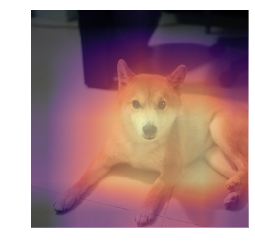

In [0]:
## create model and train
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
idx = 0
x,y = data.valid_ds[idx]
t = x.data

xb,_  = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])

from fastai.callbacks.hooks import *

def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g
  
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');
    
hook_a,hook_g = hooked_backward()  

acts  = hook_a.stored[0].cpu()
print(acts.shape)  

avg_acts = acts.mean(0)
print(avg_acts.shape)

show_heatmap(avg_acts)

In [0]:
learn.fit_one_cycle(2)

learn.save('pet-classifer-stage-1')

In [0]:
## interp of learning model
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15,11))
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)
interp.most_confused(min_val=2)

## unfreezing, fine-tuning and learning rates

## unfreeze() says train the whole model.
learn.unfreeze()
learn.fit_one_cycle(1)

## find the learning rate
learn.lr_find()

learn.recorder.plot()
plt.title("Loss Vs Learning Rate")

## train with updated lr
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))
